In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [2]:
def f(abscissa):
    return 2 * abscissa ** 2 + abscissa + 1

In [3]:
NUM_EXAMPLES = 1000

In [4]:
data_x = np.linspace(-2, 2, NUM_EXAMPLES)
data_x = tf.cast(data_x, tf.float32)
noise = tf.random.normal(shape=[NUM_EXAMPLES])
data_y_true = f(data_x)
data_y = data_y_true + noise

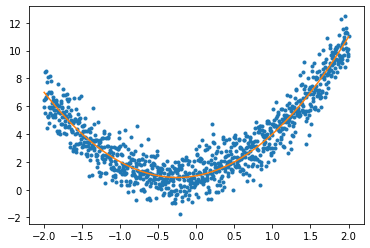

In [5]:
plt.plot(data_x, data_y, '.', label='Data')
plt.plot(data_x, data_y_true, label='Ground truth')
plt.show()

In [6]:
initializer = tf.keras.initializers.GlorotUniform()


class CustomDense(tf.keras.layers.Layer):
    _out_features: int
    _activation: Callable[[tf.Tensor], tf.Tensor]
    _weights: tf.Variable
    _biases: tf.Variable

    def __init__(self, out_features: int, activation: Callable[[tf.Tensor], tf.Tensor] = tf.identity, **kwargs):
        super().__init__(**kwargs)
        self._out_features = out_features
        self._activation = activation

    def build(self, input_shape):
        # demonstrate different ways of weights initialization
        self._weights = self.add_weight(
                shape=(input_shape[-1], self._out_features),
                initializer=initializer,
                name='weights'
        )
        self._biases = tf.Variable(tf.zeros([self._out_features]), name='biases')

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        return self._activation(tf.matmul(inputs, self._weights) + self._biases)


In [7]:
input_layer = tf.keras.Input(shape=(1,))
layer = CustomDense(32, activation=tf.nn.relu)(input_layer)
layer = CustomDense(32, activation=tf.nn.relu)(layer)
layer = CustomDense(16, activation=tf.nn.relu)(layer)
layer = CustomDense(16, activation=tf.nn.relu)(layer)
layer = CustomDense(8, activation=tf.nn.relu)(layer)
layer = CustomDense(8, activation=tf.nn.relu)(layer)
layer = CustomDense(4)(layer)
layer = CustomDense(2)(layer)
layer = CustomDense(1)(layer)

model = tf.keras.Model(inputs=input_layer, outputs=layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 custom_dense (CustomDense)  (None, 32)                64        
                                                                 
 custom_dense_1 (CustomDense  (None, 32)               1056      
 )                                                               
                                                                 
 custom_dense_2 (CustomDense  (None, 16)               528       
 )                                                               
                                                                 
 custom_dense_3 (CustomDense  (None, 16)               272       
 )                                                               
                                                             

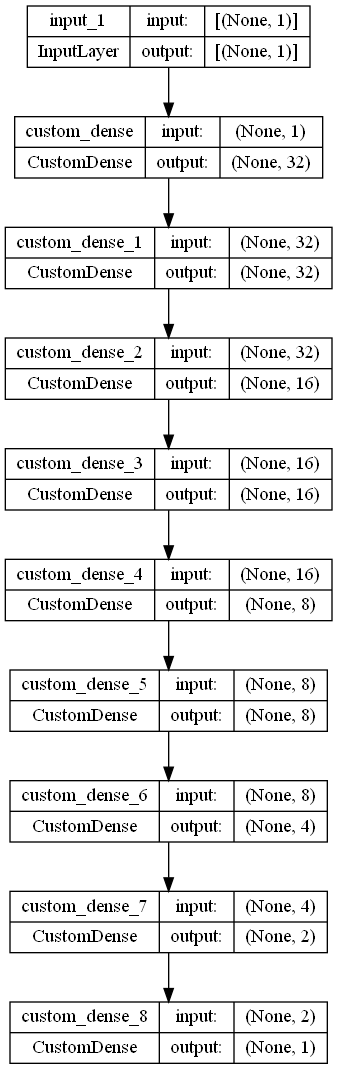

In [8]:
tf.keras.utils.plot_model(model, '../../output/model_architecture.png', show_shapes=True)

In [9]:
model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss=tf.keras.losses.mean_squared_error,
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [10]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir='../../output/logs',
        write_graph=False,
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=0,
)
model.fit(data_x,
          data_y,
          validation_split=0.1,
          epochs=500,
          batch_size=NUM_EXAMPLES,
          callbacks=[early_stopping_callback, tensorboard_callback],
          )

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 12.1291 - mean_absolute_error: 2.8431 - val_loss: 67.7685 - val_mean_absolute_error: 8.1062
Epoch 2/500
1/1 [==============================] - 0s 70ms/step - loss: 8.0391 - mean_absolute_error: 2.1929 - val_loss: 52.7278 - val_mean_absolute_error: 7.1211
Epoch 3/500
1/1 [==============================] - 0s 65ms/step - loss: 5.0242 - mean_absolute_error: 1.7136 - val_loss: 39.3068 - val_mean_absolute_error: 6.1109
Epoch 4/500
1/1 [==============================] - 0s 65ms/step - loss: 3.6593 - mean_absolute_error: 1.5112 - val_loss: 33.1406 - val_mean_absolute_error: 5.5871
Epoch 5/500
1/1 [==============================] - 0s 66ms/step - loss: 3.3812 - mean_absolute_error: 1.4854 - val_loss: 30.6034 - val_mean_absolute_error: 5.3577
Epoch 6/500
1/1 [==============================] - 0s 66ms/step - loss: 3.1661 - mean_absolute_error: 1.4370 - val_loss: 27.5133 - val_mean_absolute_error: 5.0643
Epoch 7/500
1/1 [======

In [11]:
evaluation_results = model.evaluate(data_x, data_y, batch_size=NUM_EXAMPLES, verbose=0)
print(f'final loss: {evaluation_results[0]}')
print(f'final mean_absolute_error: {evaluation_results[1]}')

final loss: 1.688073992729187
final mean_absolute_error: 1.0589053630828857


In [12]:
prediction_result = model.predict(data_x, batch_size=NUM_EXAMPLES).reshape((-1,))
prediction_result

1/1 [==============================] - 0s 100ms/step


array([7.0176783, 7.0022416, 6.986804 , 6.971367 , 6.95593  , 6.9404926,
       6.925056 , 6.9096184, 6.8941817, 6.8787446, 6.8633075, 6.84787  ,
       6.832433 , 6.8169956, 6.8015585, 6.7861214, 6.770685 , 6.755247 ,
       6.73981  , 6.724373 , 6.7089367, 6.693498 , 6.678062 , 6.662625 ,
       6.6471863, 6.6317506, 6.616312 , 6.600876 , 6.585439 , 6.570001 ,
       6.554564 , 6.5391273, 6.5236897, 6.5082526, 6.4928155, 6.4773784,
       6.461942 , 6.446504 , 6.4310665, 6.41563  , 6.4001923, 6.3847566,
       6.369319 , 6.3538814, 6.338445 , 6.3230076, 6.30757  , 6.2921333,
       6.276697 , 6.261259 , 6.2458215, 6.230385 , 6.214948 , 6.199511 ,
       6.1840725, 6.1686363, 6.1531997, 6.137762 , 6.1223245, 6.106888 ,
       6.09145  , 6.076014 , 6.060577 , 6.04514  , 6.0297017, 6.014265 ,
       5.9988284, 5.9833913, 5.9679537, 5.952519 , 5.9371057, 5.9216914,
       5.9062757, 5.8908615, 5.8754473, 5.860032 , 5.844618 , 5.8292036,
       5.8137894, 5.7983747, 5.7829604, 5.767546 , 

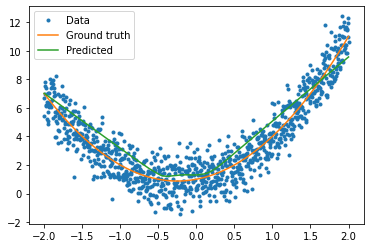

In [13]:
plt.plot(data_x, data_y, '.', label='Data')
plt.plot(data_x, data_y_true, label='Ground truth')
plt.plot(data_x, prediction_result, label='Predicted')
plt.legend()
plt.show()